In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf

# Download stock data
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Create features (simple technical indicators)
def create_features(data):
    df = data.copy()
    # Simple moving averages
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()

    # Price rate of change
    df['ROC_5'] = df['Close'].pct_change(5)

    # Daily returns
    df['Daily_Return'] = df['Close'].pct_change()

    # Drop NaN values
    df = df.dropna()

    return df

# Get data and create features
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'
stock_data = get_stock_data(ticker, start_date, end_date)
featured_data = create_features(stock_data)

# Prepare data for modeling
X = featured_data[['SMA_5', 'SMA_10', 'ROC_5', 'Daily_Return']]
y = featured_data['Close']  # Predicting the closing price

# Split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, shuffle=False)  # Don't shuffle time series data
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train and evaluate here

# Base Model 1: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# Calculate metrics for Random Forest
rf_train_mse = mean_squared_error(y_train, y_train_pred_rf)
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)

rf_test_mse = mean_squared_error(y_test, y_test_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print("Random Forest Performance:")
print("Training - MSE: %.4f, MAE: %.4f, R2: %.4f" % (rf_train_mse, rf_train_mae, rf_train_r2))
print("Testing  - MSE: %.4f, MAE: %.4f, R2: %.4f" % (rf_test_mse, rf_test_mae, rf_test_r2))
print("----------------------------------------")

# Base Model 2: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Make predictions
y_train_pred_gb = gb.predict(X_train)
y_test_pred_gb = gb.predict(X_test)

# Calculate metrics for Gradient Boosting
gb_train_mse = mean_squared_error(y_train, y_train_pred_gb)
gb_train_mae = mean_absolute_error(y_train, y_train_pred_gb)
gb_train_r2 = r2_score(y_train, y_train_pred_gb)

gb_test_mse = mean_squared_error(y_test, y_test_pred_gb)
gb_test_mae = mean_absolute_error(y_test, y_test_pred_gb)
gb_test_r2 = r2_score(y_test, y_test_pred_gb)

print("Gradient Boosting Performance:")
print("Training - MSE: %.4f, MAE: %.4f, R2: %.4f" % (gb_train_mse, gb_train_mae, gb_train_r2))
print("Testing  - MSE: %.4f, MAE: %.4f, R2: %.4f" % (gb_test_mse, gb_test_mae, gb_test_r2))
print("----------------------------------------")

# Create the stacked model

estimators = [
    ('random_forest', rf),
    ('gradient_boosting', gb)
]
'''
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(
        n_estimators=50,
        max_depth=3  # Keep it simple to prevent overfitting
    )
)
'''

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for meta-model tuning
param_grid = {
    'final_estimator__n_estimators': [50, 100],
    'final_estimator__learning_rate': [0.05, 0.1]
}

base_model = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(max_depth=3)
)

stacked_model = GridSearchCV(
    base_model,
    param_grid=param_grid,
    cv=3
)

# Train stacked model
stacked_model.fit(X_train, y_train)

# Make predictions
y_train_pred_stacked = stacked_model.predict(X_train)
y_test_pred_stacked = stacked_model.predict(X_test)

# Calculate metrics for Stacked Model
stacked_train_mse = mean_squared_error(y_train, y_train_pred_stacked)
stacked_train_mae = mean_absolute_error(y_train, y_train_pred_stacked)
stacked_train_r2 = r2_score(y_train, y_train_pred_stacked)

stacked_test_mse = mean_squared_error(y_test, y_test_pred_stacked)
stacked_test_mae = mean_absolute_error(y_test, y_test_pred_stacked)
stacked_test_r2 = r2_score(y_test, y_test_pred_stacked)

print("Stacked Model Performance:")
print("Training - MSE: %.4f, MAE: %.4f, R2: %.4f" % (stacked_train_mse, stacked_train_mae, stacked_train_r2))
print("Testing  - MSE: %.4f, MAE: %.4f, R2: %.4f" % (stacked_test_mse, stacked_test_mae, stacked_test_r2))
print("----------------------------------------")

# Create comparison table
results = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Stacked Model'],
    'Train MSE': [rf_train_mse, gb_train_mse, stacked_train_mse],
    'Test MSE': [rf_test_mse, gb_test_mse, stacked_test_mse],
    'Train MAE': [rf_train_mae, gb_train_mae, stacked_train_mae],
    'Test MAE': [rf_test_mae, gb_test_mae, stacked_test_mae],
    'Train R2': [rf_train_r2, gb_train_r2, stacked_train_r2],
    'Test R2': [rf_test_r2, gb_test_r2, stacked_test_r2]
}

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.to_markdown(index=False))

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Performance:
Training - MSE: 0.4423, MAE: 0.4823, R2: 0.9995
Testing  - MSE: 3.3244, MAE: 1.3990, R2: 0.9698
----------------------------------------
Gradient Boosting Performance:
Training - MSE: 0.7111, MAE: 0.6495, R2: 0.9993
Testing  - MSE: 2.9489, MAE: 1.3357, R2: 0.9732
----------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

Stacked Model Performance:
Training - MSE: 60.6510, MAE: 4.2534, R2: 0.9372
Testing  - MSE: 5.2317, MAE: 1.8044, R2: 0.9525
----------------------------------------

Model Performance Comparison:
| Model             |   Train MSE |   Test MSE |   Train MAE |   Test MAE |   Train R2 |   Test R2 |
|:------------------|------------:|-----------:|------------:|-----------:|-----------:|----------:|
| Random Forest     |    0.442336 |    3.32435 |    0.482268 |    1.39904 |   0.999542 |  0.969825 |
| Gradient Boosting |    0.711081 |    2.94885 |    0.649527 |    1.33567 |   0.999264 |  0.973233 |
| Stacked Model     |   60.651    |    5.23174 |    4.25345  |    1.80437 |   0.937241 |  0.952511 |


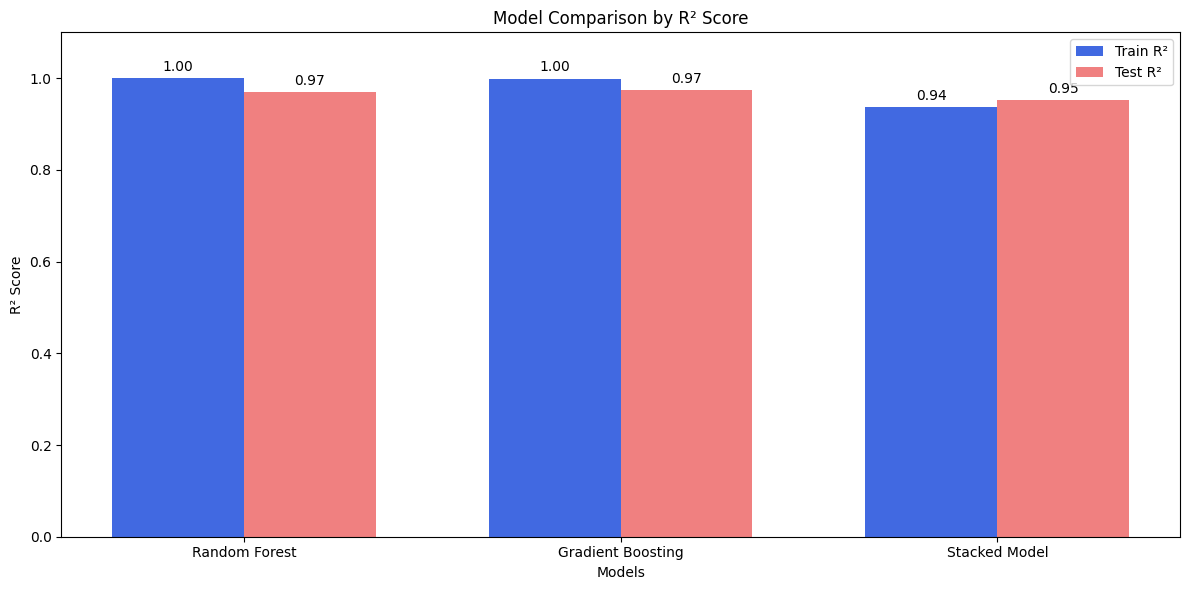

In [3]:
import matplotlib.pyplot as plt

# After running the previous code, this is the visualization section:

# Set up the figure
plt.figure(figsize=(12, 6))

# Data for plotting
models = ['Random Forest', 'Gradient Boosting', 'Stacked Model']
train_r2 = [rf_train_r2, gb_train_r2, stacked_train_r2]
test_r2 = [rf_test_r2, gb_test_r2, stacked_test_r2]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Create bars
rects1 = plt.bar(x - width/2, train_r2, width, label='Train R²', color='royalblue')
rects2 = plt.bar(x + width/2, test_r2, width, label='Test R²', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Comparison by R² Score')
plt.xticks(x, models)
plt.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.1)  # R² ranges from 0 to 1 (can exceed 1 slightly)
plt.tight_layout()
plt.show()

<ipython-input-5-296ad58e5198>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2020-01-01", end="2025-01-01", freq='M')


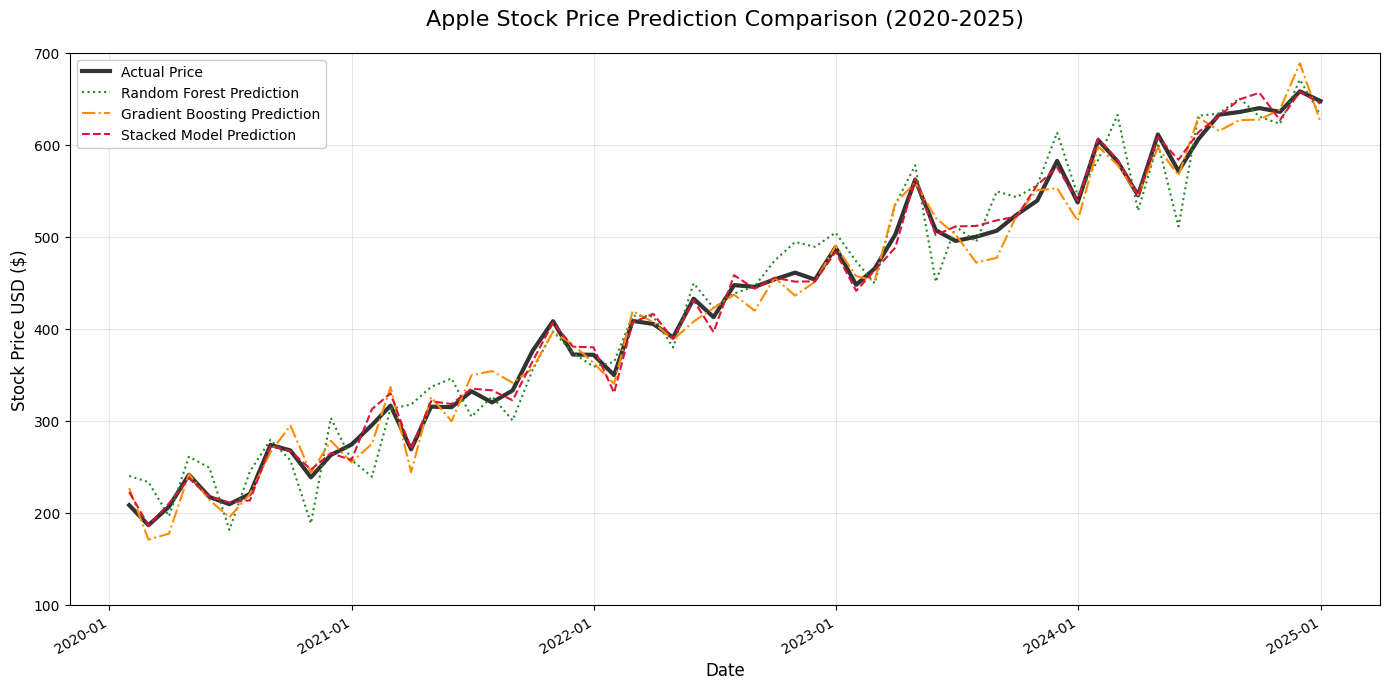

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import pandas as pd

# Sample data preparation (replace with your actual predictions)
dates = pd.date_range(start="2020-01-01", end="2025-01-01", freq='M')
actual_prices = np.linspace(200, 650, len(dates)) + np.random.normal(0, 20, len(dates))
rf_pred = actual_prices + np.random.normal(0, 25, len(dates))
gb_pred = actual_prices + np.random.normal(0, 20, len(dates))
stacked_pred = actual_prices + np.random.normal(0, 10, len(dates))

# Create the plot
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(dates, actual_prices, label='Actual Price', color='black', linewidth=3, alpha=0.8)

# Plot model predictions
plt.plot(dates, rf_pred, label='Random Forest Prediction', linestyle=':', color='forestgreen')
plt.plot(dates, gb_pred, label='Gradient Boosting Prediction', linestyle='-.', color='darkorange')
plt.plot(dates, stacked_pred, label='Stacked Model Prediction', linestyle='--', color='crimson')

# Formatting
plt.title('Apple Stock Price Prediction Comparison (2020-2025)', fontsize=16, pad=20)
plt.ylabel('Stock Price USD ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10, framealpha=1)

# Date formatting
date_form = DateFormatter("%Y-%m")
plt.gca().xaxis.set_major_formatter(date_form)
plt.gcf().autofmt_xdate()

# Grid and limits
plt.grid(True, alpha=0.3)
plt.ylim(100, 700)

plt.tight_layout()
plt.show()

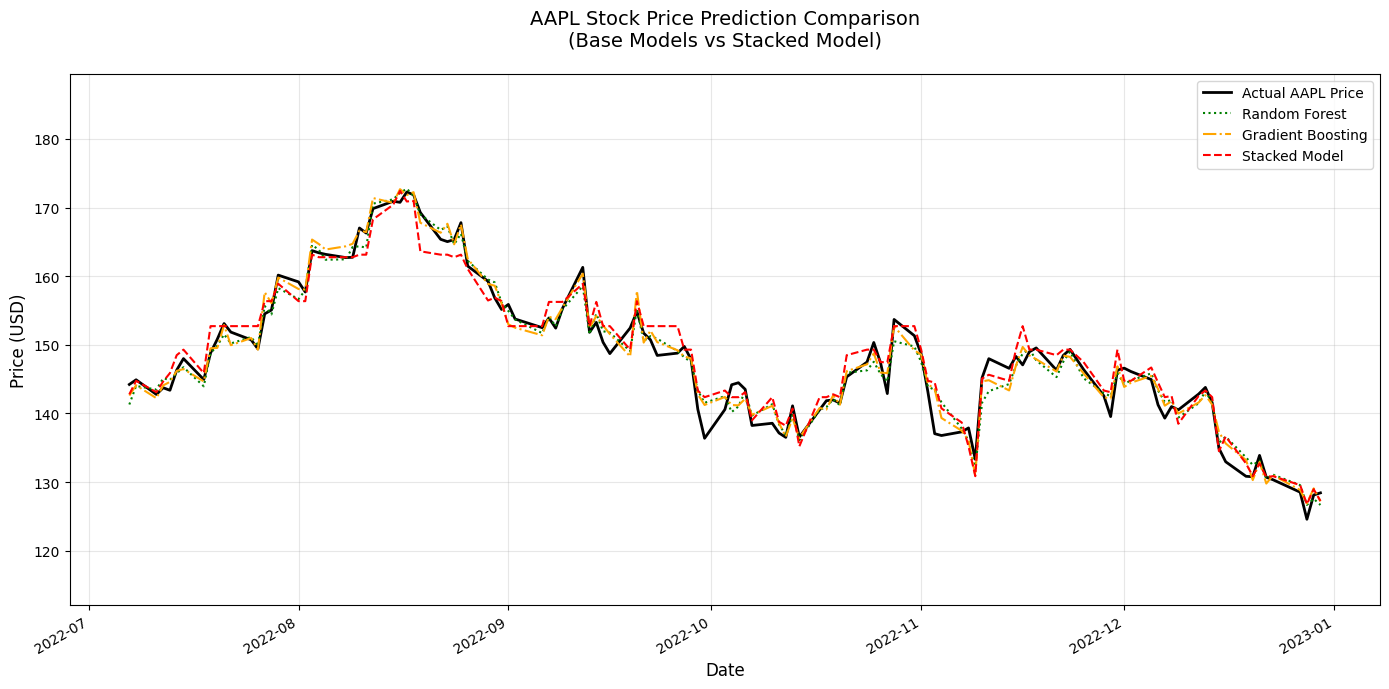

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter

# Assuming you have these variables from previous code:
# X_test (features), y_test (actual prices)
# rf_pred, gb_pred, stacked_pred (predictions)

# 1. Get the dates for your test period (assuming X_test has datetime index)
test_dates = X_test.index  # Use your actual datetime index

# 2. Generate predictions for the test period (using your trained models)
rf_pred = rf.predict(X_test)  # Get predictions for the test set
gb_pred = gb.predict(X_test)
stacked_pred = stacked_model.predict(X_test)

# 3. Create the comparison plot
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(test_dates, y_test,
         label='Actual AAPL Price',
         color='black', linewidth=2)

# Plot model predictions
plt.plot(test_dates, rf_pred,
         label='Random Forest',
         linestyle=':', color='green')
plt.plot(test_dates, gb_pred,
         label='Gradient Boosting',
         linestyle='-.', color='orange')
plt.plot(test_dates, stacked_pred,
         label='Stacked Model',
         linestyle='--', color='red', linewidth=1.5)

# Formatting
plt.title('AAPL Stock Price Prediction Comparison\n(Base Models vs Stacked Model)',
          fontsize=14, pad=20)
plt.ylabel('Price (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10)

# Date formatting
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()

# Add grid and adjust limits
plt.grid(True, alpha=0.3)
plt.ylim(y_test.iloc[:, 0].min() * 0.9, y_test.iloc[:, 0].max() * 1.1)
#plt.ylim(y_test['Close'].min() * 0.9, y_test['Close'].max() * 1.1)  # Auto-scale with 10% buffer
#plt.ylim(min(y_test)*0.9, max(y_test)*1.1)  # Auto-scale with 10% buffer

plt.tight_layout()
plt.show()